<h1>    Welcome to the notebook!
    
    Just hit run on each cell to run it!

In [35]:
# just import, doesnt matter
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

<h1>THIS SECTION IS FOR UNDERSTANDING: WE USE ONLY ONE FILE</h1>

<h2>Here we read the data!
At the moment we read only one file</h2> 

In [179]:
data = []
with open('data/aegeancore2.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            data.append((float(row[0]),float(str(row[1]).replace(',', '.'))))
            line_count += 1
raw_data = np.asarray(data)                  
    #print(f'Processed {line_count} lines.')

Column names are AgeBP, d18O


<h2>Plot the data!</h2>

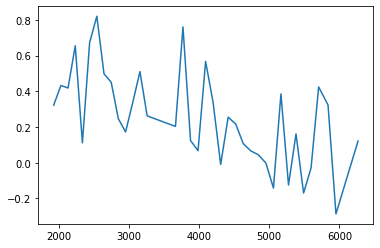

In [34]:
#plotting the raw data
plt.plot(raw_data[:,0], raw_data[:,1])

<h1>Let the magic of interpolation happen</h1>

<h2>But first, we need to set the actual time sampling! How much we want?</h2>

In [96]:
# 5 sample each 200 years?
numbers_of_samples = 10 # change the number here if you want!
year_interval = 200
average_sampling_team = np.mean(raw_data[1:,0]-raw_data[:-1,0])
year_range = raw_data[0,0], raw_data[-1,0]
step_size = (year_interval / numbers_of_samples)
print("this data has an average distance of",average_sampling_team,"years between values", )

this data has an average distance of 120.63888888888889 years between values


<h1>LINEAR INTERPOLATION</h1>

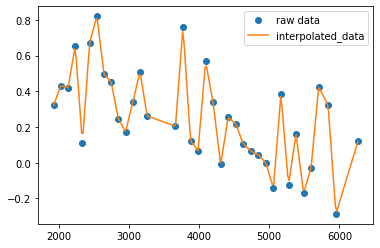

In [148]:
#linear interpolation
linear_f = interpolate.interp1d(raw_data[:,0], raw_data[:,1], kind='linear')
xnew = np.arange(raw_data[0,0], raw_data[-1,0], step_size)
y_linear = linear_f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(raw_data[:,0], raw_data[:,1], 'o', label='raw data')
plt.plot(xnew, y_linear, '-', label='interpolated_data')
plt.legend()

<h1>QUADRATIC INTERPOLATION</h1>

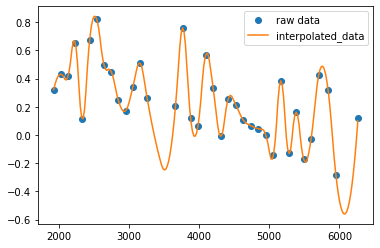

In [149]:
#quadratic interpolation
quadratic_f = interpolate.interp1d(raw_data[:,0], raw_data[:,1], kind='quadratic')
y_quadratic = quadratic_f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(raw_data[:,0], raw_data[:,1], 'o', label='raw data')
plt.plot(xnew, y_quadratic, '-', label='interpolated_data')
plt.legend()

<h2>you can see the difference between 3000 and 4000! It changes a lot! Yet I believe the quadratic is wrong. If you plot them together, you see</h2>

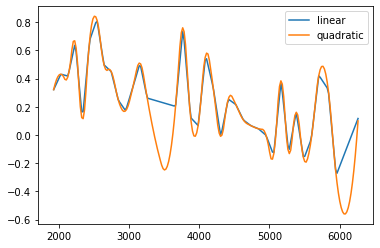

In [146]:
plt.plot(xnew, y_linear, '-', label='linear')
plt.plot(xnew, y_quadratic, '-', label='quadratic')
plt.legend()

<h2>This is what I meant when I talked about different interpolation and the drawing I was trying to make.
Unfortunately, I don't see this as much better. Let's check another one</h2>

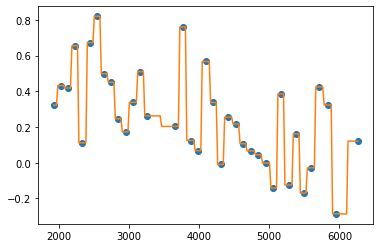

In [102]:
#quadratic interpolation
nearest_n = interpolate.interp1d(raw_data[:,0], raw_data[:,1], kind='nearest')
y_nearest = nearest_n(xnew)   # use interpolation function returned by `interp1d`
plt.plot(raw_data[:,0], raw_data[:,1], 'o', xnew, y_nearest, '-')

<h2>Also, not very satisfactory. Here we should do the work. I will investigate how to re-sample this better. Let's see what we can do</h2>

<h2>Now we can check the z-score</h2>

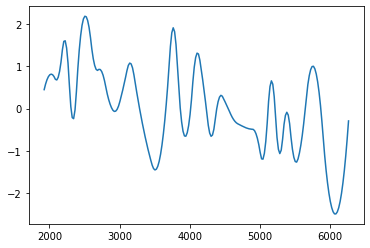

In [136]:
interp_data = y_quadratic # here change if you prefere linear interpolation
mean_value = np.mean(interp_data)
std_dev = np.std(interp_data)
z_score = (interp_data - mean_value ) / std_dev
plt.plot(xnew, z_score, '-')

<h2>What about the z-score with different interpolations?</h2>

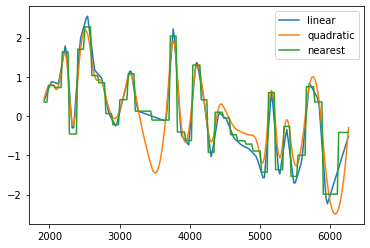

In [137]:
i_q = y_quadratic
i_l = y_linear
i_nn = y_nearest
mean_value = np.mean(i_l)
std_dev = np.std(i_l)
z_linear = (i_l - mean_value ) / std_dev
plt.plot(xnew, z_linear, '-', label="linear")

mean_value = np.mean(i_q)
std_dev = np.std(i_q)
z_quadr = (i_q - mean_value ) / std_dev
plt.plot(xnew, z_quadr, '-', label="quadratic")

mean_value = np.mean(i_nn)
std_dev = np.std(i_nn)
z_near = (i_nn - mean_value ) / std_dev
plt.plot(xnew, z_near, '-', label="nearest")

plt.legend()

<h2>No big difference, apart from the big curve in the 3500. 
Let's pick linear interpolation and quadratic (you can change by changing the code) and throw the data into bins</h2>

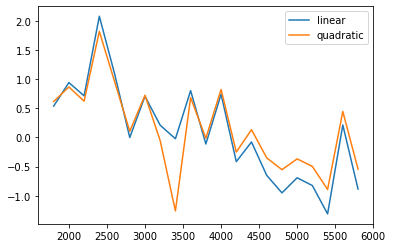

In [144]:
ranges = np.arange(1800, 6200, year_interval)
binned_z_score_linear = []
binned_z_score_quadr = []
for i in range(len(ranges)-1):
    lb = ranges[i]
    ub = ranges[i+1]
    mask = np.logical_and(xnew >= lb, xnew <= ub )
    binned_z_score_linear.append(z_linear[mask].mean())
    binned_z_score_quadr.append(z_quadr[mask].mean())

binned_z_score_linear = np.asarray(binned_z_score_linear)
binned_z_score_quadr = np.asarray(binned_z_score_quadr)
plt.plot(ranges[:-1], binned_z_score_linear, '-', label='linear')
plt.plot(ranges[:-1], binned_z_score_quadr, '-', label='quadratic')
plt.legend()

<h2>ok, there is a slight difference, yet not sure what that means. Let's take a look at all the data together<h2>

<h1>NOW EVERYTHING SEEMS TO WORK! LET'S TRY WITH ALL THE DATA</h1>

In [185]:
import os
big_data = []
name_for_plotting = []
filenames = os.listdir('data')
for filename in filenames:
    if filename[0] == ".":
        continue
    else:
        name_for_plotting.append(filename[:-4])
        data_cur_file = []
        print("reading", name_for_plotting[-1])
        full_path_file = "{}/{}".format('data',filename)
        with open(full_path_file) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=';')
            line_count = 0
            for row in csv_reader:
                if line_count == 0:
                    #print(f'Column names are {", ".join(row)}')
                    line_count += 1
                else:
                    age = str(row[0]).replace(',', '.')
                    isotop = str(row[1]).replace(',', '.')
                    data_cur_file.append((float(age), float(isotop)))
                    line_count += 1

        cur_data = np.asarray(data_cur_file)    
        big_data.append(cur_data)
big_data = np.asarray(big_data)  
print(big_data.shape)

reading levantcore2
reading levant
reading akgol
reading bafa
reading aegeancore2
reading marmarasea
reading sofular_tr
reading mavri_gr
reading aegean
reading jeita
reading soreq
reading nar
reading acigol
(13,)


<h1>PLOT ALL THE DATA!</h1>

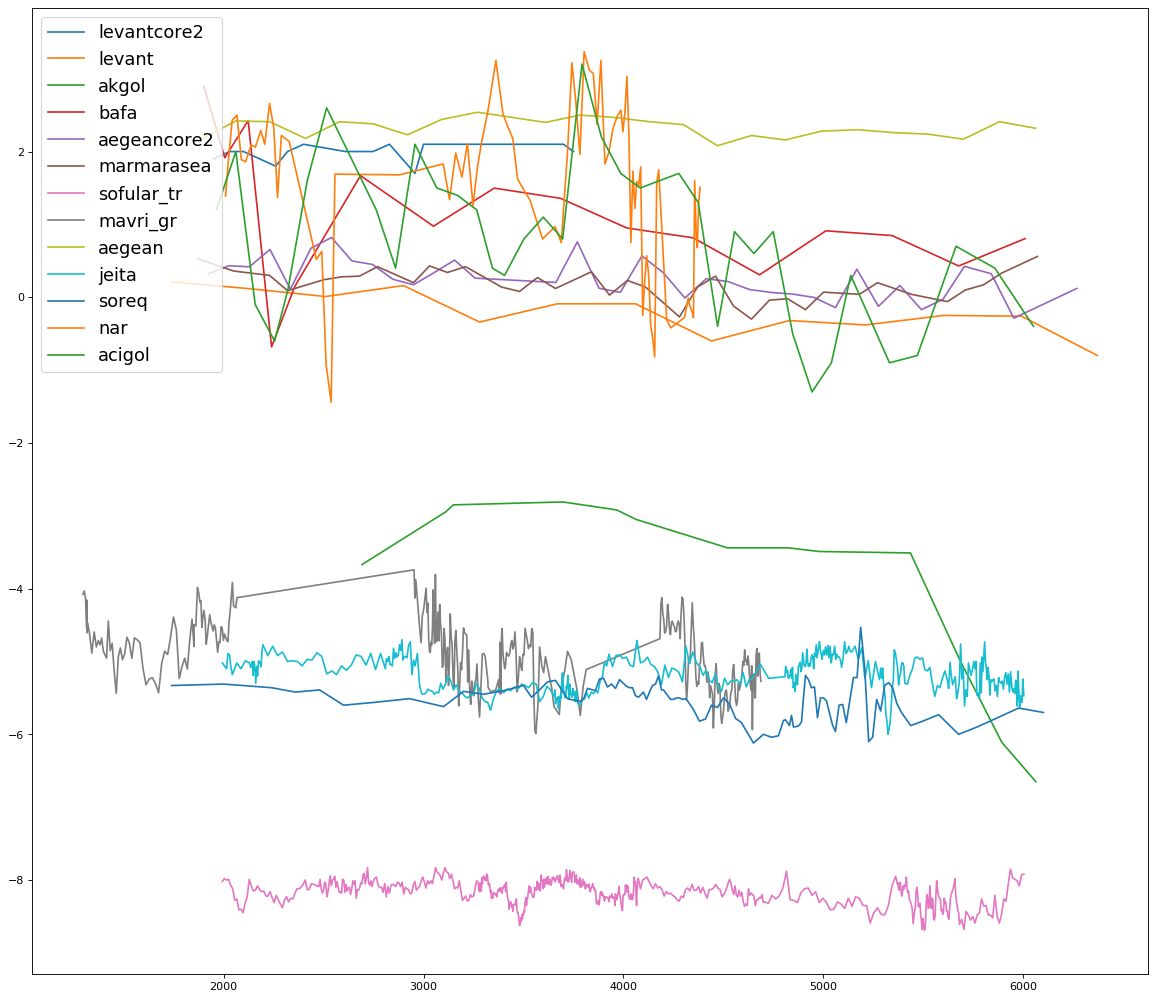

In [192]:
plt.figure(figsize=(18, 16), dpi= 80)
for j in range(len(big_data)):
    plt.plot(big_data[j][:,0], big_data[j][:,1], label=name_for_plotting[j])
plt.legend(fontsize=16)